# Pré-Processamento e Divisão (Treino vs. Teste)

In [1]:
# Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

In [2]:
# Configuração visual
sns.set_theme(style="whitegrid")

# 1. Carregar os dados processados (com index sendo a data)
df = pd.read_csv("../data/processed/df_modelagem.csv", index_col="data", parse_dates=True)

# 2. Seleção de Features (X) e Target (y)
# Vamos focar na inadimplência Pessoa Física (PF)
target = "inad_pf_tot"

# Remover colunas que não usaremos na predição
# (Removemos o próprio target e outras inadimplências que seriam "spoiler")
# Também vamos remover a coluna 'presidente' original (texto) e converter em números (One-Hot Encoding)
cols_to_drop = [
    target, 
    "inad_ctrl_pub_tot", "inad_ctrl_priv_nac_tot", "inad_ctrl_est_tot", "inad_ctrl_priv_tot",
    "inad_ger_tot", "inad_pj_tot", "inad_pf_tot", "inad_rl_tot", "inad_rl_pj_tot",
    "inad_rl_pj_dup_rec", "inad_rl_pj_desc_chq", "inad_rl_pj_ant_fat_cart", 
    "inad_rl_pj_cap_giro_365", "inad_rl_pj_cap_giro_365_mais", "inad_rl_pj_cap_giro_rot",
    "inad_rl_pj_cap_giro_tot", "inad_rl_pj_cont_gar", "inad_rl_pj_chq_esp", "inad_rl_pj_veic",
    "inad_rl_pj_out_bens", "inad_rl_pj_bens_tot", "inad_rl_pj_arr_merc_veic", "inad_rl_pj_arr_merc_out",
    "inad_rl_pj_arr_merc_tot", "inad_rl_pj_vendor", "inad_rl_pj_compor", "inad_rl_pj_cart_rot",
    "inad_rl_pj_cart_parc", "inad_rl_pj_cart_tot", "inad_rl_pj_ad_contr_camb", "inad_rl_pj_fin_imp",
    "inad_rl_pj_fin_exp", "inad_rl_pj_rep_ext", "inad_rl_pj_out_cred_rl", "inad_rl_pf_tot",
    "inad_rl_pf_chq_esp", "inad_rl_pf_cred_pes_nc", "inad_rl_pf_cred_pes_nc_vinc_div", "inad_rl_pf_cred_pes_con_priv",
    "inad_rl_pf_cred_pes_con_pub", "inad_rl_pf_cred_pes_con_inss", "inad_rl_pf_cred_pes_con_tot", "inad_rl_pf_cred_pes_tot",
    "inad_rl_pf_veic", "inad_rl_pf_out_bens", "inad_rl_pf_bens_tot", "inad_rl_pf_arr_merc_veic",
    "inad_rl_pf_arr_merc_out", "inad_rl_pf_arr_merc_tot", "inad_rl_pf_cart_rot", "inad_rl_pf_cart_parc",
    "inad_rl_pf_cart_tot", "inad_rl_pf_desc_chq", "inad_rl_pf_out_cred_rl"
]

# Garantir que removemos apenas o que existe no df
cols_to_drop = [c for c in cols_to_drop if c in df.columns]

X = df.drop(columns=cols_to_drop)
y = df[target]

In [3]:
# 3. Tratamento de Variáveis Categóricas (Dummies)
# O modelo matemático só aceita números. Temos que converter "Lula", "Bolsonaro" em colunas 0 e 1.
# Como já lemos o CSV, precisamos recriar a dummy se a coluna presidente não estiver lá, 
# mas se você usou get_dummies antes, ok. Vamos garantir aqui:
if "presidente" in df.columns:
    X = pd.get_dummies(X, columns=["presidente"], drop_first=True)

# 4. Divisão Cronológica (Time Series Split)
# Vamos usar 80% do tempo para treino e 20% para teste
train_size = int(len(df) * 0.80)

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"Período de Treino: {X_train.index.min()} até {X_train.index.max()} ({len(X_train)} meses)")
print(f"Período de Teste:  {X_test.index.min()} até {X_test.index.max()} ({len(X_test)} meses)")

# 5. Padronização (StandardScaler)
# O modelo precisa que "Selic" e "Renda" estejam na mesma escala numérica.
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converter de volta para DataFrame para ficar bonito
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

display(X_train_scaled.head())

Período de Treino: 2016-01-01 00:00:00 até 2023-12-01 00:00:00 (96 meses)
Período de Teste:  2024-01-01 00:00:00 até 2025-12-01 00:00:00 (24 meses)


,inad_rd_pf_cr_rur_tot,inad_rd_pj_cr_rur_tot,ipca,spread_pf,spread_pj,spread_tot,selic,cdi,dolar_ptax,rendimento_medio_mensal_reais,...,tx_desocupacao_p14m_pct_lag_12,rendimento_medio_mensal_reais_lag_3,rendimento_medio_mensal_reais_lag_6,rendimento_medio_mensal_reais_lag_12,dolar_ptax_lag_3,dolar_ptax_lag_6,dolar_ptax_lag_12,presidente_Dilma,presidente_Lula,presidente_Temer
data,,,,,,,,,,,,,,,,,,,,,
2016-01-01,-0.033951,-0.360426,1.209289,0.687829,1.230545,0.403468,1.277607,1.276729,-0.370522,-1.213895,...,-1.917054,-1.686168,-1.637094,-1.643602,-0.529948,-1.231134,-1.693317,3.316625,-0.377964,-0.641689
2016-02-01,0.169757,-0.375743,-0.107515,0.936888,1.517135,0.702298,1.277607,1.275261,-0.461065,-1.213895,...,-1.917054,-1.686168,-1.637094,-1.643602,-0.649606,-0.897539,-1.491891,3.316625,-0.377964,-0.641689
2016-03-01,0.309806,-0.370637,-0.833693,1.237300,1.574453,0.978141,1.277607,1.275261,-0.771856,-1.213895,...,-1.917054,-1.686168,-1.637094,-1.643602,-0.540338,-0.448234,-1.134820,3.316625,-0.377964,-0.641689
2016-04-01,0.233415,-0.365532,0.182957,1.563388,1.517135,1.250152,1.277607,1.275261,-0.930892,-1.213895,...,-1.710329,-1.124975,-1.637094,-1.643602,-0.331194,-0.478389,-1.241222,3.316625,-0.377964,-0.641689
2016-05-01,0.169757,-0.360426,0.870405,1.691769,1.536241,1.376580,1.277607,1.275261,-0.961479,-1.213895,...,-1.710329,-1.124975,-1.637094,-1.643602,-0.421918,-0.597177,-1.220778,3.316625,-0.377964,-0.641689


# 1. Random Forest Regressor (Floresta Aleatória)

Treinando Random Forest...


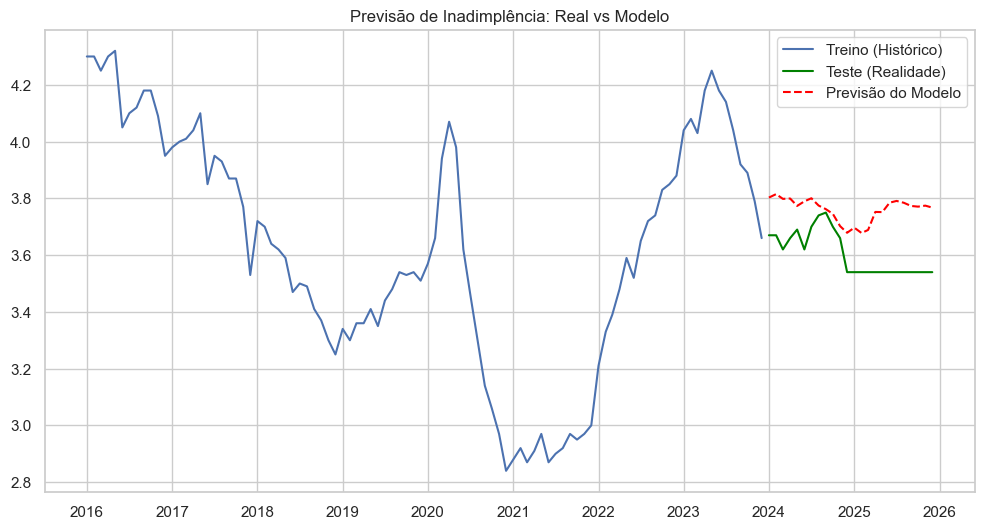

RMSE (Erro Quadrático Médio): 0.1723
MAE (Erro Absoluto Médio): 0.1565


In [4]:
# 6. Treinamento
print("Treinando Random Forest...")
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train_scaled, y_train)

# 7. Previsões
y_pred = model_rf.predict(X_test_scaled)

# 8. Avaliação Inicial (Gráfico)
plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label="Treino (Histórico)")
plt.plot(y_test.index, y_test, label="Teste (Realidade)", color="green")
plt.plot(y_test.index, y_pred, label="Previsão do Modelo", color="red", linestyle="--")

plt.title("Previsão de Inadimplência: Real vs Modelo")
plt.legend()
plt.show()

# Métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE (Erro Quadrático Médio): {rmse:.4f}")
print(f"MAE (Erro Absoluto Médio): {mae:.4f}")

C:\Users\pedro\AppData\Local\Temp\ipykernel_1752\2326668913.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances.head(15), x='importance', y='feature', palette='viridis')


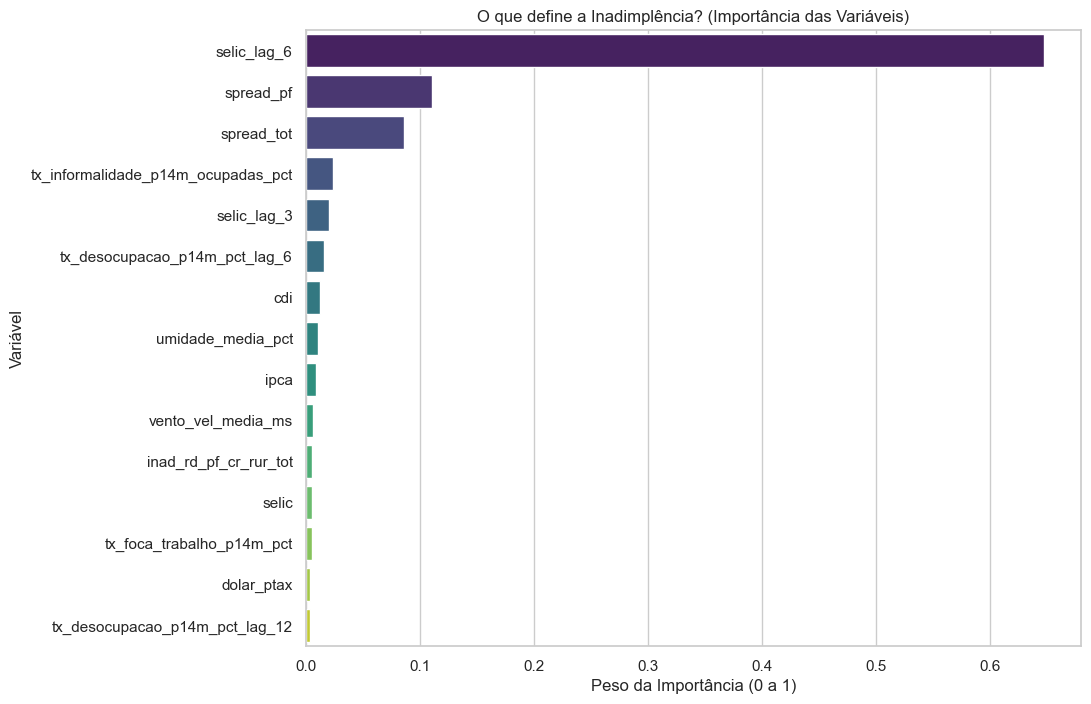

                               feature  importance
31                         selic_lag_6    0.647657
3                            spread_pf    0.110206
5                           spread_tot    0.085686
10  tx_informalidade_p14m_ocupadas_pct    0.023622
30                         selic_lag_3    0.020057
37       tx_desocupacao_p14m_pct_lag_6    0.015398
7                                  cdi    0.011873
22                   umidade_media_pct    0.010163
2                                 ipca    0.009092
24                  vento_vel_media_ms    0.006225


In [5]:
# 9. Feature Importance (O que o modelo aprendeu?)
# Extrair a importância das features
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model_rf.feature_importances_
}).sort_values(by='importance', ascending=False)

# Plotar as Top 15 mais importantes
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importances.head(15), x='importance', y='feature', palette='viridis')
plt.title("O que define a Inadimplência? (Importância das Variáveis)")
plt.xlabel("Peso da Importância (0 a 1)")
plt.ylabel("Variável")
plt.show()

# Mostrar a tabela textual
print(feature_importances.head(10))

--- TESTE COM AUTOREGRESSÃO ---
Novo RMSE: 0.0810
Novo MAE: 0.0690


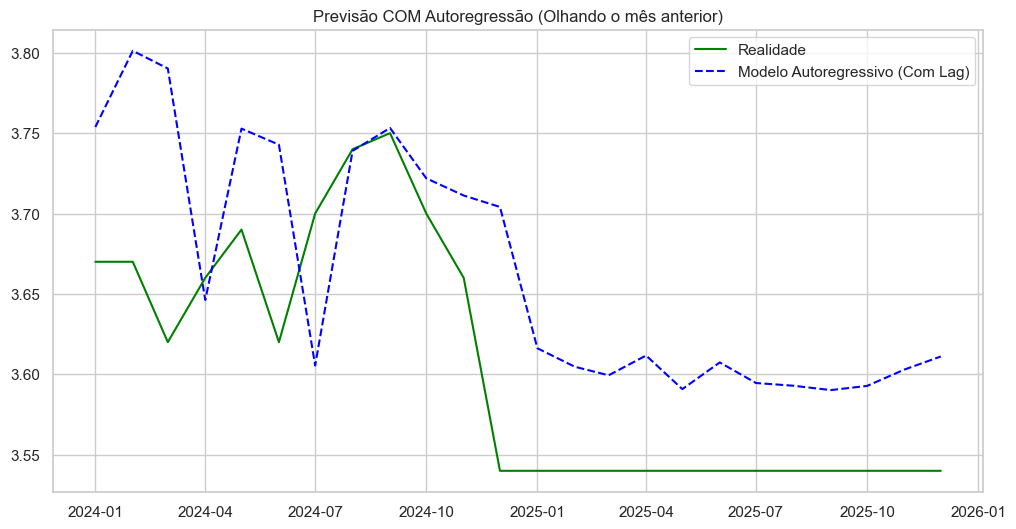

In [6]:
print("--- TESTE COM AUTOREGRESSÃO ---")

# 1. Criar a feature 'target_lag_1' (Valor do mês anterior) no DataFrame original processado
df_auto = df.copy()
df_auto["target_lag_1"] = df_auto[target].shift(1)
df_auto = df_auto.dropna()

# 2. Refazer X e y
X_auto = df_auto.drop(columns=cols_to_drop) # As mesmas colunas dropadas antes
y_auto = df_auto[target]

# 3. Dummies (garantir presidente se existir)
if "presidente" in df_auto.columns:
    X_auto = pd.get_dummies(X_auto, columns=["presidente"], drop_first=True)

# 4. Divisão Treino/Teste
train_size_auto = int(len(df_auto) * 0.80)
X_train_a, X_test_a = X_auto.iloc[:train_size_auto], X_auto.iloc[train_size_auto:]
y_train_a, y_test_a = y_auto.iloc[:train_size_auto], y_auto.iloc[train_size_auto:]

# 5. Padronização
scaler_a = StandardScaler()
X_train_a_sc = scaler_a.fit_transform(X_train_a)
X_test_a_sc = scaler_a.transform(X_test_a)

# 6. Treinar Novo Modelo
model_rf_auto = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf_auto.fit(X_train_a_sc, y_train_a)

# 7. Prever e Avaliar
y_pred_a = model_rf_auto.predict(X_test_a_sc)

rmse_a = np.sqrt(mean_squared_error(y_test_a, y_pred_a))
mae_a = mean_absolute_error(y_test_a, y_pred_a)

print(f"Novo RMSE: {rmse_a:.4f}")
print(f"Novo MAE: {mae_a:.4f}")

# Plot Comparativo
plt.figure(figsize=(12, 6))
plt.plot(y_test_a.index, y_test_a, label="Realidade", color="green")
plt.plot(y_test_a.index, y_pred_a, label="Modelo Autoregressivo (Com Lag)", color="blue", linestyle="--")
plt.title("Previsão COM Autoregressão (Olhando o mês anterior)")
plt.legend()
plt.show()

In [7]:
# Salvar o modelo campeão (com autoregressão)
joblib.dump(model_rf_auto, "../models/model_final.pkl")

# Salvar o scaler (fundamental para os dados novos terem a mesma escala)
joblib.dump(scaler_a, "../models/scaler_final.pkl")

# Salvar uma amostra dos dados (X_train) para pegarmos as médias das outras variáveis
# Isso serve para preencher o que o usuário não mexer no simulador
X_train_a.to_csv("../data/processed/X_train_sample.csv", index=False)

print("Artefatos salvos na pasta models/ e data/processed!")

Artefatos salvos na pasta models/ e data/processed!
